# Sampling Strategy code development for ligands selection

B) Ligands sampling dataframe:

3) Ligands that have covalent Metal-Ligand connections to specific atoms (e.g. M*-C* bonds) Select highest-propensity ligands from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
4) Ligands that have non-covalent (not first-coordination shell) metal-ligand connections to specific atoms (e.g. M*-N-C* bonds) from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
5) Ensure that ligands selected cover as much known differences in chemistry as possible (e.g. Oxygen vs Water vs. Hydroxyl vs. Oxo ...) - this definition can be a bit Nebulous I'm working on starting with different atom types as a measure of different chemistries.


In [56]:
import pandas as pd
from architector import view_structures,convert_io_molecule
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ligdf = pd.read_pickle('reduced_ligand_df.pkl')

In [3]:
ligdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency
0,"O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]2,4,8,15",O=C([O-])CN1CCCN(CCC1)CC(=O)[O-],"[2, 4, 8, 15]","O,N,N,O","O.co2,N.3,N.3,O.co2","O,C,C,C,C,C,C,C,C,C,C,O,H,H,H,H,H,H,H,H,H,H,H,...","O.co2,C.2,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.2,...",-2,4,"Ni,2",4
1,O0,O,[0],O,O.3,"H,H","H,H",0,1,"Ni,2",22519
2,CC(=O)[O-]3,CC(=O)[O-],[3],O,O.co2,"C,C,O,H,H,H","C.3,C.2,O.co2,H,H,H",-1,1,"Al,3",1444
3,[CH3-]0,[CH3-],[0],C,C.2,"H,H,H","H,H,H",-1,1,"Al,3",7084
6,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,"[12, 21]","N,N","N.pl3,N.ar","C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,C.3,C...",-1,2,"Al,3",1
...,...,...,...,...,...,...,...,...,...,...,...
356430,"C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC220,23",C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC2,"[20, 23]","S,S","S.3,S.3","C,C,O,C,C,N,C,C,O,C,C,O,C,C,N,C,C,O,C,C,C,C,C,...","C.3,C.3,O.3,C.3,C.3,N.3,C.3,C.3,O.3,C.3,C.3,O....",0,2,"Pd,2",1
356431,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O8,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O,[8],N,N.ar,"N,C,N,C,N,C,N,C,C,C,O,C,C,O,P,O,O,O,C,O,C,O,H,...","N.pl3,C.ar,N.ar,C.ar,N.ar,C.ar,N.ar,C.ar,C.ar,...",-2,1,"Ni,2",1
356449,NC(=S)NN(CC(O)=O)CC(O)=O2,NC(=S)NN(CC(O)=O)CC(O)=O,[2],S,S.2,"N,C,N,N,C,C,O,O,C,C,O,O,H,H,H,H,H,H,H,H,H","N.am,C.2,N.am,N.3,C.3,C.2,O.3,O.2,C.3,C.2,O.3,...",0,1,"Co,2",1
356539,CCOc1cc[c-]cc16,CCOc1cc[c-]cc1,[6],C,C.2,"C,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H,H","C.3,C.3,O.3,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H...",-1,1,"Sn,4",4


In [6]:
# Iterate over all atom types
all_atom_types = set()
for i,row in ligdf.iterrows():
    all_atom_types.update(row['coord_atom_types'].split(','))
    all_atom_types.update(row['non_coord_atom_types'].split(','))
all_atom_types.remove('')
all_atom_types = list(all_atom_types)

In [8]:
len(all_atom_types)

32

In [10]:
# Note, no shared full pattern among these types! Works well for searching.
for x in all_atom_types:
    print(x)

C.cat
O.co2
S.O
N.2
Te
I
Si
N.am
S.2
O.3
S.O2
C.2
Sb
As
Cl
O.2
C.1
N.pl3
S.3
H
Se
C.3
P.3
N.1
N.4
B
N.ar
C.ar
F
Ge
Br
N.3


In [28]:
coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed coordinated to metals in experiments!'.format(t))

This atom type C.cat does not exist in the ligands observed coordinated to metals in experiments!
This atom type S.O2 does not exist in the ligands observed coordinated to metals in experiments!
This atom type C.1 does not exist in the ligands observed coordinated to metals in experiments!
This atom type H does not exist in the ligands observed coordinated to metals in experiments!


In [29]:
non_coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.non_coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed not coordinated to metals in experiments!'.format(t))

In [30]:
coorddf = pd.concat(coord_atom_samples)
noncoorddf = pd.concat(non_coord_atom_samples)

In [33]:
print(noncoorddf.shape[0],noncoorddf.drop_duplicates(subset='uid').shape[0])
print(coorddf.shape[0],coorddf.drop_duplicates(subset='uid').shape[0])

640 564
542 508


In [34]:
noncoorddf.iloc[0]

uid                                                         CN(C)C(=N)N(C)C4
smiles                                                       CN(C)C(=N)N(C)C
coordList                                                                [4]
coord_atom_symols                                                          N
coord_atom_types                                                       N.pl3
non_coord_atom_symbols               C,N,C,C,N,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H
non_coord_atom_types       C.3,N.pl3,C.3,C.cat,N.pl3,C.3,C.3,H,H,H,H,H,H,...
charge                                                                     0
denticity                                                                  1
metal_ox_bound                                                          Dy,3
frequency                                                                 47
selected_coord_type                                                     None
selected_non_coord_type                                                C.cat

In [36]:
coorddf.iloc[0]

uid                         O=N(=O)[O-]3
smiles                       O=N(=O)[O-]
coordList                            [3]
coord_atom_symols                      O
coord_atom_types                   O.co2
non_coord_atom_symbols             O,N,O
non_coord_atom_types       O.2,N.pl3,O.2
charge                                -1
denticity                              1
metal_ox_bound                      Cu,2
frequency                           1742
selected_coord_type                O.co2
selected_non_coord_type             None
Name: 75, dtype: object

In [37]:
combineddf = pd.concat([coorddf,noncoorddf])
outdf = combineddf.drop_duplicates(subset='uid')

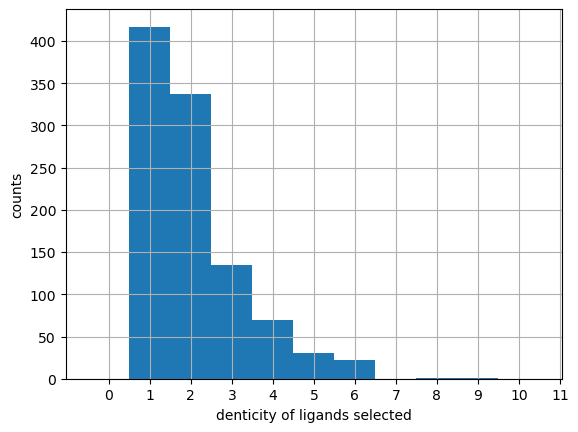

In [43]:
ax = outdf.denticity.hist(bins=np.arange(0,12,1),align='left')
ax.set_xlabel('denticity of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(np.arange(0,12,1));

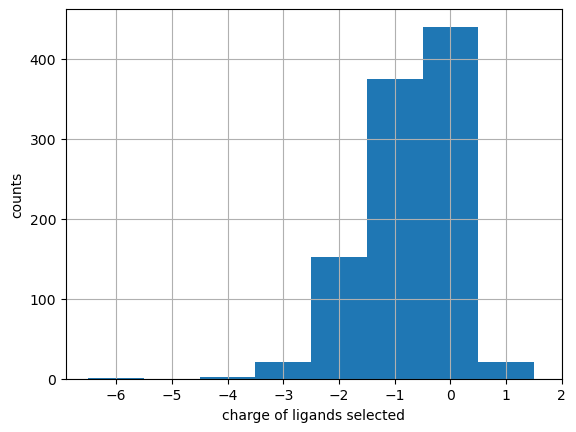

In [46]:
bins = np.arange(-6,3,1)
ax = outdf.charge.hist(bins=bins,align='left')
ax.set_xlabel('charge of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins);

Text(0, 0.5, 'counts')

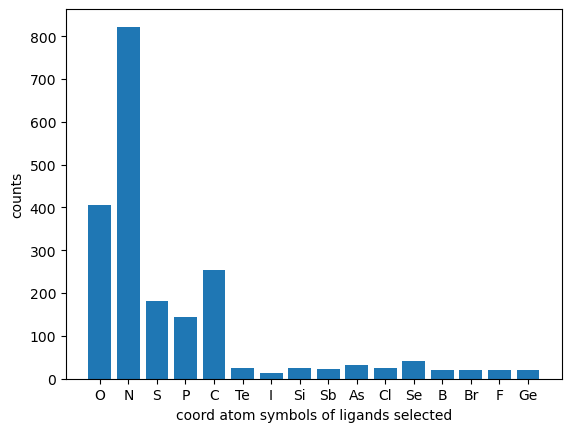

In [53]:
coord_atom_symbols = dict()
for i,row in outdf.iterrows():
    syms = row['coord_atom_symols'].split(',')
    vals,counts = np.unique(syms,return_counts=True)
    for j,val in enumerate(vals):
        coord_atom_symbols.update({val:coord_atom_symbols.get(val,0)+counts[j]})
syms = list(coord_atom_symbols.keys())
vals = list(coord_atom_symbols.values())
plt.bar(syms,vals)
plt.xlabel('coord atom symbols of ligands selected')
plt.ylabel('counts')

In [57]:
# Calculate number of atoms per-ligand
natoms = [] 
for i,row in outdf.iterrows():
    mol = convert_io_molecule(row['smiles']) # Including H
    natoms.append(len(mol.ase_atoms))
outdf['natoms'] = natoms

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES


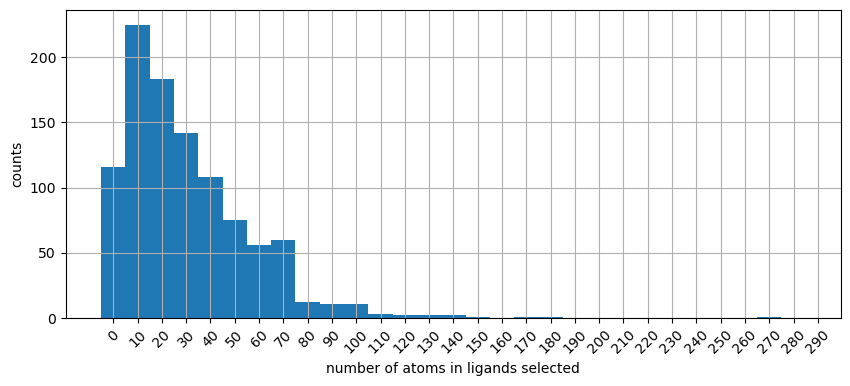

In [65]:
# Note - we should possibly down-select for number of atoms
bins = np.arange(0,300,10)
ax = outdf.natoms.hist(bins=bins,align='left',figsize=(10,4))
ax.set_xlabel('number of atoms in ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins)
ax.set_xticklabels(bins,rotation=45);

In [66]:
outdf.to_pickle('v0_ligand_sampling_df.pkl')

In [67]:
outdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency,selected_coord_type,selected_non_coord_type,natoms
75,O=N(=O)[O-]3,O=N(=O)[O-],[3],O,O.co2,"O,N,O","O.2,N.pl3,O.2",-1,1,"Cu,2",1742,O.co2,None,4
493,FC(F)(F)S(=O)(=O)[O-]7,FC(F)(F)S(=O)(=O)[O-],[7],O,O.co2,"F,C,F,F,S,O,O","F,C.3,F,F,S.3,O.2,O.2",-1,1,"Cu,2",1596,O.co2,None,8
2,CC(=O)[O-]3,CC(=O)[O-],[3],O,O.co2,"C,C,O,H,H,H","C.3,C.2,O.co2,H,H,H",-1,1,"Al,3",1444,O.co2,None,7
356,O=[Cl](=O)(=O)[O-]4,O=[Cl](=O)(=O)[O-],[4],O,O.co2,"O,Cl,O,O","O.2,Cl,O.2,O.2",-1,1,"Zn,2",1195,O.co2,None,5
5513,CC(C)[O-]3,CC(C)[O-],[3],O,O.co2,"C,C,C,H,H,H,H,H,H,H","C.3,C.3,C.3,H,H,H,H,H,H,H",-1,1,"Zr,4",679,O.co2,None,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49425,"[NH3+]CCNCCN1CN2CCN(CCN)CC(C)(C1)C23,6,11,14",[NH3+]CCNCCN1CN2CCN(CCN)CC(C)(C1)C2,"[3, 6, 11, 14]","N,N,N,N","N.3,N.3,N.3,N.3","N,C,C,C,C,C,N,C,C,C,C,C,C,C,C,C,H,H,H,H,H,H,H,...","N.4,C.3,C.3,C.3,C.3,C.3,N.3,C.3,C.3,C.3,C.3,C....",1,4,"Cu,2",1,None,N.3,53
193536,C1CN(Cc2ccccn2)P2N(CCN1CCN2Cc1ccccn1)Cc1ccccn1...,C1CN(Cc2ccccn2)P2N(CCN1CCN2Cc1ccccn1)Cc1ccccn1,"[9, 10, 24]","N,P,N","N.ar,P.3,N.ar","C,C,N,C,C,C,C,C,C,N,C,C,N,C,C,N,C,C,C,C,C,C,C,...","C.3,C.3,N.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,N.3,C...",0,3,"Ni,2",3,None,N.3,62
14161,Cc1cc(CN2CCCC2C(O)(c2ccccc2)c2ccccc2)c([O-])c(...,Cc1cc(CN2CCCC2C(O)(c2ccccc2)c2ccccc2)c([O-])c(...,"[11, 25, 34]","O,O,O","O.3,O.co2,O.3","C,C,C,C,C,N,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.ar,C.ar,C.ar,C.3,N.3,C.3,C.3,C.3,C.3,C.3...",-1,3,"Y,3",5,None,N.3,93
148054,CSc1ccc(cc1)c1ccc(C=NCCN(CCN=Cc2ccc(cc2[O-])c2...,CSc1ccc(cc1)c1ccc(C=NCCN(CCN=Cc2ccc(cc2[O-])c2...,"[13, 19, 27, 38, 46, 56]","N,N,O,N,O,O","N.2,N.2,O.co2,N.2,O.co2,O.co2","C,S,C,C,C,C,C,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,C,...","C.3,S.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.a...",-3,6,"Ga,3",3,None,N.3,103


In [68]:
view_structures(outdf.sample(10,random_state=42).smiles)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol